## Convolutional Neural Network for MNIST image classficiation 

In [28]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [2]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

In [3]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [4]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


 72%|███████▏  | 72/100 [00:00<00:00, 326.78it/s]

iteration 0, reconstruction error 8.355367
iteration 10, reconstruction error 2.829290
iteration 20, reconstruction error 1.871674
iteration 30, reconstruction error 1.721685
iteration 40, reconstruction error 1.661760
iteration 50, reconstruction error 1.646562
iteration 60, reconstruction error 1.652228
iteration 70, reconstruction error 1.664508


100%|██████████| 100/100 [00:00<00:00, 370.50it/s]

iteration 80, reconstruction error 1.669948
iteration 90, reconstruction error 1.666991
reconstruction error (relative) = 0.004323
Dictionary error (relative) = 0.866895
Code error (relative) = 19.410251


# Learn dictionary of MNIST images 

In [193]:
def display_dictionary(W, save_name=None, score=None, grid_shape=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=(6, 6)
    if (score is not None) and (grid_shape is None):
       figsize0=(6, 7)
    if (score is not None) and (grid_shape is not None):
       figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [105]:
def display_dictionary_list(W_list, label_list, save_name=None, score_list=None):
    # Make plot
    
    # outer gridspec
    nrows=1
    ncols=len(W_list)
    fig = plt.figure(figsize=(16, 5), constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    
    
    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))
        sub_rows = int(np.sqrt(W_list[i].shape[1]))
        sub_cols = int(np.sqrt(W_list[i].shape[1]))

        idx = np.arange(W_list[i].shape[1])
        if score_list is not None:
            idx = np.argsort(score_list[i])
            idx = np.flip(idx)    
        
        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j // sub_cols 
            b = j % sub_cols #sub-lattice indices

            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[idx[j]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xticks([])
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                ax.set_title(label_list[i], y=1.2, fontsize=14)
            if (score_list is not None) and (score_list[i] is not None):
                ax.set_xlabel('%1.2f' % score_list[i][idx[j]], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.07)
           
                
                
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.savefig(save_name, bbox_inches='tight')

In [166]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [ ]:
# Unconstrained matrix factorization and dictionary images 

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)

  6%|▌         | 3/50 [00:00<00:06,  7.61it/s]

iteration 0, reconstruction error 6363.156588


 26%|██▌       | 13/50 [00:01<00:03,  9.88it/s]

iteration 10, reconstruction error 1983.255977


 44%|████▍     | 22/50 [00:01<00:02, 11.96it/s]

iteration 20, reconstruction error 1580.950348


 64%|██████▍   | 32/50 [00:02<00:01, 11.22it/s]

iteration 30, reconstruction error 1435.934107


 72%|███████▏  | 36/50 [00:03<00:01, 11.65it/s]

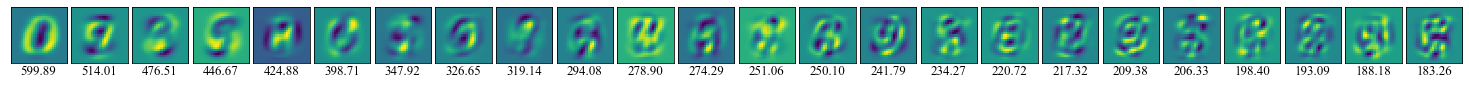

In [179]:
# PCA and dictionary images (principal components)

pca = PCA(n_components=24)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "MNIST_PCA_ex1.pdf", grid_shape=[1,24])

 20%|██        | 2/10 [00:00<00:01,  5.79it/s]

iteration 0, reconstruction error 6280.724813


 20%|██        | 2/10 [00:00<00:01,  6.74it/s]

iteration 0, reconstruction error 4790.895784


 20%|██        | 2/10 [00:00<00:01,  5.98it/s]

iteration 0, reconstruction error 4815.398723


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


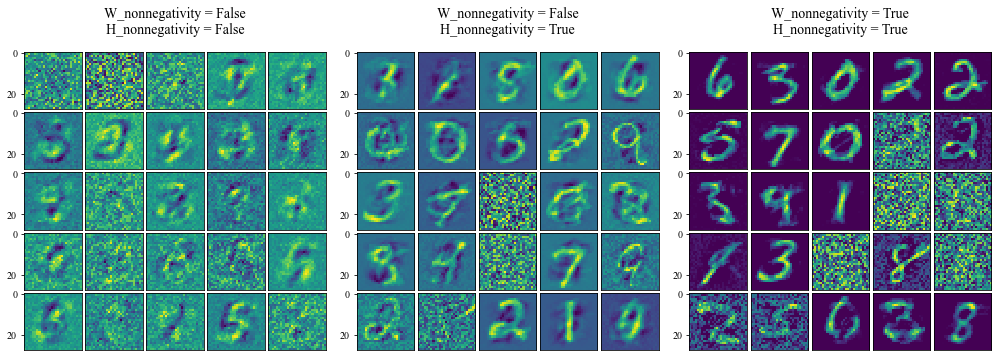

In [103]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 10
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    


label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex1.pdf")



  1%|          | 1/100 [00:00<00:14,  6.66it/s]

!!! nonnegativitiy[i] [False, False]
iteration 0, reconstruction error 6399.593827


 13%|█▎        | 13/100 [00:01<00:08,  9.77it/s]

iteration 10, reconstruction error 1951.330135


 22%|██▏       | 22/100 [00:02<00:07, 10.67it/s]

iteration 20, reconstruction error 1565.912512


 32%|███▏      | 32/100 [00:03<00:05, 12.73it/s]

iteration 30, reconstruction error 1422.051409


 42%|████▏     | 42/100 [00:04<00:06,  9.52it/s]

iteration 40, reconstruction error 1334.601910


 52%|█████▏    | 52/100 [00:05<00:06,  7.95it/s]

iteration 50, reconstruction error 1278.209372


 62%|██████▏   | 62/100 [00:06<00:06,  6.31it/s]

iteration 60, reconstruction error 1243.906783


 73%|███████▎  | 73/100 [00:08<00:02,  9.51it/s]

iteration 70, reconstruction error 1222.113766


 82%|████████▏ | 82/100 [00:08<00:01, 10.95it/s]

iteration 80, reconstruction error 1206.138127


 92%|█████████▏| 92/100 [00:10<00:01,  7.28it/s]

iteration 90, reconstruction error 1193.658128


  2%|▏         | 2/100 [00:00<00:07, 13.05it/s]

!!! nonnegativitiy[i] [False, True]
iteration 0, reconstruction error 4883.843259


 12%|█▏        | 12/100 [00:01<00:10,  8.03it/s]

iteration 10, reconstruction error 1521.797554


 21%|██        | 21/100 [00:02<00:09,  8.55it/s]

iteration 20, reconstruction error 1162.662822


 32%|███▏      | 32/100 [00:03<00:07,  9.16it/s]

iteration 30, reconstruction error 1077.614481


 42%|████▏     | 42/100 [00:04<00:07,  7.80it/s]

iteration 40, reconstruction error 1044.781975


 52%|█████▏    | 52/100 [00:05<00:04,  9.97it/s]

iteration 50, reconstruction error 1030.289019


 63%|██████▎   | 63/100 [00:07<00:03,  9.30it/s]

iteration 60, reconstruction error 1023.496191


 72%|███████▏  | 72/100 [00:07<00:02, 10.95it/s]

iteration 70, reconstruction error 1020.042681


 82%|████████▏ | 82/100 [00:09<00:02,  8.68it/s]

iteration 80, reconstruction error 1018.144818


 91%|█████████ | 91/100 [00:09<00:00, 10.99it/s]

iteration 90, reconstruction error 1017.012511


  0%|          | 0/100 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [True, True]


  3%|▎         | 3/100 [00:00<00:18,  5.24it/s]

iteration 0, reconstruction error 4879.501206


 12%|█▏        | 12/100 [00:01<00:09,  9.17it/s]

iteration 10, reconstruction error 2137.951151


 23%|██▎       | 23/100 [00:02<00:07, 10.61it/s]

iteration 20, reconstruction error 1913.794518


 32%|███▏      | 32/100 [00:03<00:06, 10.96it/s]

iteration 30, reconstruction error 1821.748220


 42%|████▏     | 42/100 [00:04<00:04, 12.29it/s]

iteration 40, reconstruction error 1745.326417


 52%|█████▏    | 52/100 [00:04<00:04, 11.08it/s]

iteration 50, reconstruction error 1699.600693


 62%|██████▏   | 62/100 [00:06<00:04,  8.98it/s]

iteration 60, reconstruction error 1686.218643


 72%|███████▏  | 72/100 [00:07<00:03,  9.33it/s]

iteration 70, reconstruction error 1673.235915


 82%|████████▏ | 82/100 [00:08<00:01, 11.57it/s]

iteration 80, reconstruction error 1656.046965


 92%|█████████▏| 92/100 [00:08<00:00, 12.42it/s]

iteration 90, reconstruction error 1644.569061


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


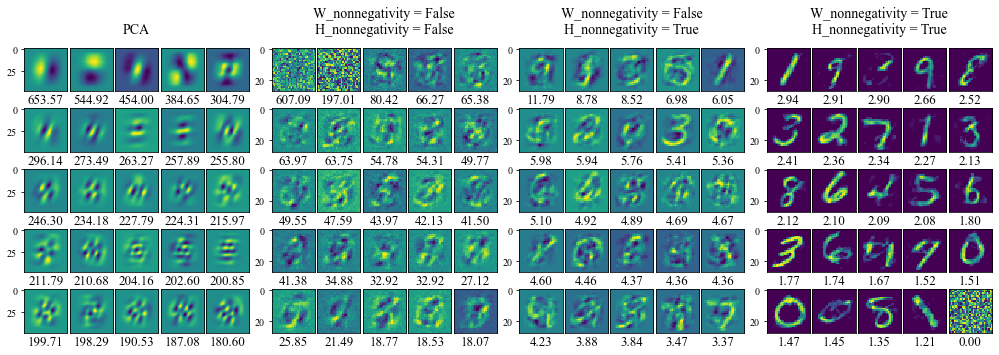

In [107]:
# MF and PCA on MNIST

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X_train)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex1.pdf")



In [10]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [11]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

  2%|▏         | 2/100 [00:00<00:17,  5.54it/s]

iteration 0, reconstruction error 12617.423067


 12%|█▏        | 12/100 [00:01<00:13,  6.50it/s]

iteration 10, reconstruction error 4439.611985


 22%|██▏       | 22/100 [00:03<00:11,  6.54it/s]

iteration 20, reconstruction error 3884.683752


 32%|███▏      | 32/100 [00:05<00:10,  6.70it/s]

iteration 30, reconstruction error 3575.311177


 42%|████▏     | 42/100 [00:06<00:10,  5.45it/s]

iteration 40, reconstruction error 3365.489620


 52%|█████▏    | 52/100 [00:08<00:07,  6.49it/s]

iteration 50, reconstruction error 3207.234974


 62%|██████▏   | 62/100 [00:10<00:07,  5.29it/s]

iteration 60, reconstruction error 3083.153554


 72%|███████▏  | 72/100 [00:12<00:05,  5.37it/s]

iteration 70, reconstruction error 2986.275539


 82%|████████▏ | 82/100 [00:13<00:02,  6.38it/s]

iteration 80, reconstruction error 2909.315633


 92%|█████████▏| 92/100 [00:15<00:01,  6.37it/s]

iteration 90, reconstruction error 2852.544191


  2%|▏         | 2/100 [00:00<00:15,  6.32it/s]

iteration 0, reconstruction error 7877.725635


 12%|█▏        | 12/100 [00:01<00:14,  6.00it/s]

iteration 10, reconstruction error 4663.681993


 21%|██        | 21/100 [00:03<00:14,  5.64it/s]

iteration 20, reconstruction error 3485.346348


 31%|███       | 31/100 [00:05<00:13,  4.93it/s]

iteration 30, reconstruction error 2874.852024


 41%|████      | 41/100 [00:07<00:12,  4.84it/s]

iteration 40, reconstruction error 2634.667553


 52%|█████▏    | 52/100 [00:09<00:07,  6.20it/s]

iteration 50, reconstruction error 2536.640432


 62%|██████▏   | 62/100 [00:11<00:05,  6.50it/s]

iteration 60, reconstruction error 2494.441371


 72%|███████▏  | 72/100 [00:12<00:04,  6.68it/s]

iteration 70, reconstruction error 2470.976037


 82%|████████▏ | 82/100 [00:14<00:02,  6.70it/s]

iteration 80, reconstruction error 2455.811787


 92%|█████████▏| 92/100 [00:15<00:01,  6.64it/s]

iteration 90, reconstruction error 2445.120672


  2%|▏         | 2/100 [00:00<00:14,  6.61it/s]

iteration 0, reconstruction error 7894.361881


 12%|█▏        | 12/100 [00:01<00:13,  6.49it/s]

iteration 10, reconstruction error 5181.812478


 22%|██▏       | 22/100 [00:03<00:12,  6.08it/s]

iteration 20, reconstruction error 4637.590869


 32%|███▏      | 32/100 [00:05<00:10,  6.39it/s]

iteration 30, reconstruction error 3930.468929


 42%|████▏     | 42/100 [00:06<00:09,  5.98it/s]

iteration 40, reconstruction error 3715.579462


 52%|█████▏    | 52/100 [00:08<00:07,  6.06it/s]

iteration 50, reconstruction error 3551.799584


 62%|██████▏   | 62/100 [00:10<00:06,  6.27it/s]

iteration 60, reconstruction error 3441.151911


 72%|███████▏  | 72/100 [00:11<00:04,  6.24it/s]

iteration 70, reconstruction error 3389.970588


 82%|████████▏ | 82/100 [00:13<00:02,  6.45it/s]

iteration 80, reconstruction error 3334.180988


 92%|█████████▏| 92/100 [00:14<00:01,  6.47it/s]

iteration 90, reconstruction error 3306.042934


100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


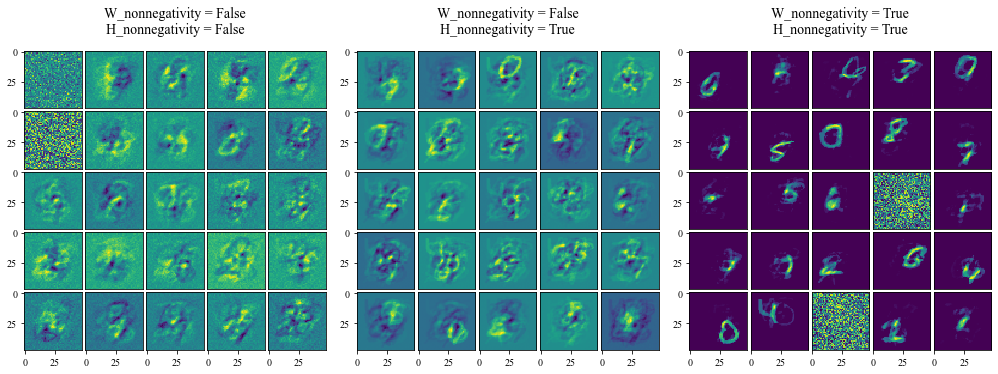

In [13]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)


idx = np.random.choice(np.arange(X_train.shape[1]), 100)
X0 = X_train[idx,:].T

n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex2.pdf")

  0%|          | 0/100 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  1%|          | 1/100 [00:00<00:25,  3.90it/s]

iteration 0, reconstruction error 12772.839031


 12%|█▏        | 12/100 [00:02<00:15,  5.55it/s]

iteration 10, reconstruction error 4324.856243


 22%|██▏       | 22/100 [00:04<00:13,  5.85it/s]

iteration 20, reconstruction error 3516.809458


 32%|███▏      | 32/100 [00:05<00:11,  6.16it/s]

iteration 30, reconstruction error 3130.460938


 42%|████▏     | 42/100 [00:07<00:09,  6.07it/s]

iteration 40, reconstruction error 2914.478314


 52%|█████▏    | 52/100 [00:09<00:07,  6.13it/s]

iteration 50, reconstruction error 2789.193313


 62%|██████▏   | 62/100 [00:10<00:06,  6.02it/s]

iteration 60, reconstruction error 2711.278977


 72%|███████▏  | 72/100 [00:12<00:04,  6.02it/s]

iteration 70, reconstruction error 2661.982013


 82%|████████▏ | 82/100 [00:14<00:03,  5.73it/s]

iteration 80, reconstruction error 2628.706675


 92%|█████████▏| 92/100 [00:16<00:01,  6.00it/s]

iteration 90, reconstruction error 2604.523447


  1%|          | 1/100 [00:00<00:18,  5.29it/s]

!!! nonnegativitiy[i] [False, True]
iteration 0, reconstruction error 7861.930493


 12%|█▏        | 12/100 [00:02<00:16,  5.29it/s]

iteration 10, reconstruction error 4391.108364


 22%|██▏       | 22/100 [00:04<00:13,  5.67it/s]

iteration 20, reconstruction error 3073.068296


 32%|███▏      | 32/100 [00:06<00:13,  5.08it/s]

iteration 30, reconstruction error 2688.367589


 42%|████▏     | 42/100 [00:07<00:10,  5.54it/s]

iteration 40, reconstruction error 2415.476939


 51%|█████     | 51/100 [00:09<00:10,  4.53it/s]

iteration 50, reconstruction error 2334.085540


 61%|██████    | 61/100 [00:11<00:08,  4.62it/s]

iteration 60, reconstruction error 2301.318510


 71%|███████   | 71/100 [00:14<00:07,  3.65it/s]

iteration 70, reconstruction error 2280.931727


 82%|████████▏ | 82/100 [00:16<00:03,  4.88it/s]

iteration 80, reconstruction error 2265.245100


 92%|█████████▏| 92/100 [00:18<00:01,  5.12it/s]

iteration 90, reconstruction error 2252.178568


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

!!! nonnegativitiy[i] [True, True]
iteration 0, reconstruction error 7824.221909


 12%|█▏        | 12/100 [00:02<00:16,  5.50it/s]

iteration 10, reconstruction error 4883.583743


 22%|██▏       | 22/100 [00:04<00:15,  5.12it/s]

iteration 20, reconstruction error 4125.648977


 32%|███▏      | 32/100 [00:05<00:12,  5.32it/s]

iteration 30, reconstruction error 3505.376376


 42%|████▏     | 42/100 [00:07<00:10,  5.61it/s]

iteration 40, reconstruction error 3266.058836


 52%|█████▏    | 52/100 [00:09<00:09,  5.19it/s]

iteration 50, reconstruction error 3168.929439


 62%|██████▏   | 62/100 [00:11<00:07,  5.37it/s]

iteration 60, reconstruction error 3093.047908


 72%|███████▏  | 72/100 [00:13<00:05,  5.32it/s]

iteration 70, reconstruction error 3060.447051


 82%|████████▏ | 82/100 [00:15<00:03,  5.67it/s]

iteration 80, reconstruction error 2988.278180


 92%|█████████▏| 92/100 [00:17<00:01,  5.76it/s]

iteration 90, reconstruction error 2928.136471


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


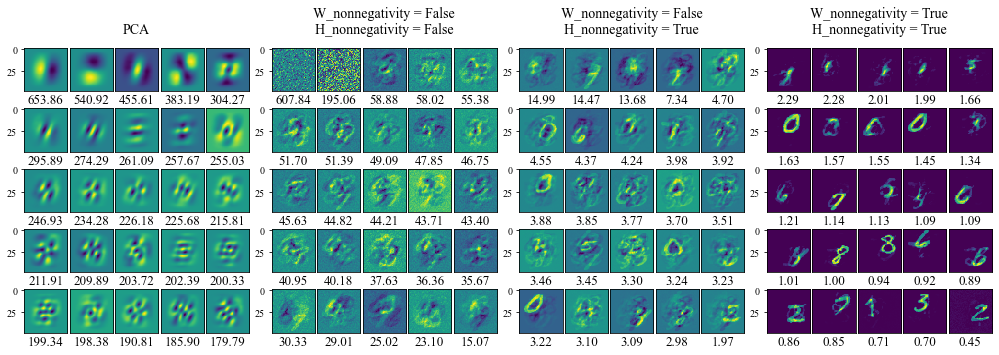

In [108]:
# MF and PCA on MNIST + padding

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)



idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X_train[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X_train)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex2.pdf")



## Dictionary Learing for Face datasets

In [63]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


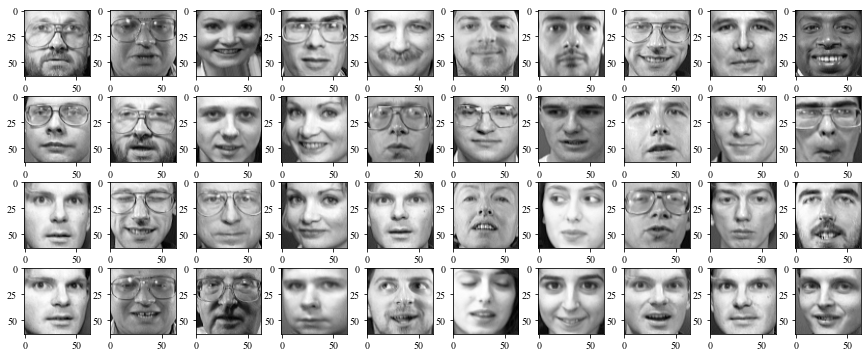

In [65]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

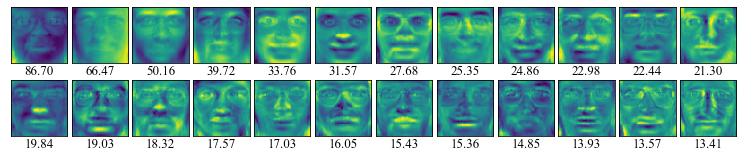

In [95]:
# PCA and dictionary images (principal components)

X0 = faces.T
pca = PCA(n_components=24)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "Faces_PCA_ex1.pdf", grid_shape=[2,12])

  0%|          | 1/200 [00:00<01:32,  2.15it/s]

iteration 0, reconstruction error 71083.313593


  6%|▌         | 11/200 [00:04<01:10,  2.68it/s]

iteration 10, reconstruction error 15703.528206


 10%|█         | 21/200 [00:07<01:05,  2.74it/s]

iteration 20, reconstruction error 12654.302855


 16%|█▌        | 31/200 [00:11<01:02,  2.71it/s]

iteration 30, reconstruction error 11523.640486


 20%|██        | 41/200 [00:15<00:57,  2.78it/s]

iteration 40, reconstruction error 10825.148822


 26%|██▌       | 51/200 [00:18<00:54,  2.75it/s]

iteration 50, reconstruction error 10307.040536


 30%|███       | 61/200 [00:22<00:50,  2.77it/s]

iteration 60, reconstruction error 9928.248219


 36%|███▌      | 71/200 [00:25<00:46,  2.80it/s]

iteration 70, reconstruction error 9634.406897


 40%|████      | 81/200 [00:29<00:42,  2.78it/s]

iteration 80, reconstruction error 9389.568464


 46%|████▌     | 91/200 [00:33<00:40,  2.70it/s]

iteration 90, reconstruction error 9177.158301


 50%|█████     | 101/200 [00:36<00:35,  2.81it/s]

iteration 100, reconstruction error 8992.981150


 56%|█████▌    | 111/200 [00:40<00:32,  2.77it/s]

iteration 110, reconstruction error 8837.735715


 60%|██████    | 121/200 [00:43<00:28,  2.80it/s]

iteration 120, reconstruction error 8703.175703


 66%|██████▌   | 131/200 [00:47<00:24,  2.77it/s]

iteration 130, reconstruction error 8589.199191


 70%|███████   | 141/200 [00:51<00:21,  2.75it/s]

iteration 140, reconstruction error 8486.934536


 76%|███████▌  | 151/200 [00:54<00:19,  2.52it/s]

iteration 150, reconstruction error 8403.220218


 80%|████████  | 161/200 [00:58<00:15,  2.51it/s]

iteration 160, reconstruction error 8332.888637


 86%|████████▌ | 171/200 [01:02<00:11,  2.63it/s]

iteration 170, reconstruction error 8273.373849


 90%|█████████ | 181/200 [01:06<00:07,  2.62it/s]

iteration 180, reconstruction error 8220.002168


 96%|█████████▌| 191/200 [01:10<00:04,  2.09it/s]

iteration 190, reconstruction error 8174.195059


  0%|          | 1/200 [00:00<01:22,  2.41it/s]

iteration 0, reconstruction error 25243.775832


  6%|▌         | 11/200 [00:04<01:14,  2.55it/s]

iteration 10, reconstruction error 8236.599730


 10%|█         | 21/200 [00:08<01:10,  2.54it/s]

iteration 20, reconstruction error 7268.978067


 16%|█▌        | 31/200 [00:12<01:06,  2.54it/s]

iteration 30, reconstruction error 7013.637740


 20%|██        | 41/200 [00:16<01:02,  2.54it/s]

iteration 40, reconstruction error 6900.823493


 26%|██▌       | 51/200 [00:20<00:59,  2.50it/s]

iteration 50, reconstruction error 6829.413391


 30%|███       | 61/200 [00:24<00:55,  2.51it/s]

iteration 60, reconstruction error 6788.579429


 36%|███▌      | 71/200 [00:28<00:51,  2.49it/s]

iteration 70, reconstruction error 6765.900671


 40%|████      | 81/200 [00:32<00:48,  2.47it/s]

iteration 80, reconstruction error 6750.450568


 46%|████▌     | 91/200 [00:36<00:43,  2.49it/s]

iteration 90, reconstruction error 6737.195036


 50%|█████     | 101/200 [00:40<00:39,  2.51it/s]

iteration 100, reconstruction error 6723.231027


 56%|█████▌    | 111/200 [00:44<00:35,  2.49it/s]

iteration 110, reconstruction error 6708.238317


 60%|██████    | 121/200 [00:48<00:32,  2.47it/s]

iteration 120, reconstruction error 6692.313572


 66%|██████▌   | 131/200 [00:52<00:28,  2.45it/s]

iteration 130, reconstruction error 6675.784017


 70%|███████   | 141/200 [00:56<00:24,  2.45it/s]

iteration 140, reconstruction error 6659.489104


 76%|███████▌  | 151/200 [01:00<00:20,  2.33it/s]

iteration 150, reconstruction error 6644.598066


 80%|████████  | 161/200 [01:04<00:15,  2.49it/s]

iteration 160, reconstruction error 6631.550147


 86%|████████▌ | 171/200 [01:08<00:11,  2.48it/s]

iteration 170, reconstruction error 6620.585172


 90%|█████████ | 181/200 [01:12<00:07,  2.47it/s]

iteration 180, reconstruction error 6612.263842


 96%|█████████▌| 191/200 [01:16<00:04,  2.06it/s]

iteration 190, reconstruction error 6605.703900


  0%|          | 1/200 [00:00<01:44,  1.90it/s]

iteration 0, reconstruction error 25346.135013


  6%|▌         | 11/200 [00:05<01:31,  2.06it/s]

iteration 10, reconstruction error 9232.828150


 10%|█         | 21/200 [00:09<01:21,  2.20it/s]

iteration 20, reconstruction error 8107.956706


 16%|█▌        | 31/200 [00:14<01:12,  2.34it/s]

iteration 30, reconstruction error 7639.710915


 20%|██        | 41/200 [00:18<01:19,  2.00it/s]

iteration 40, reconstruction error 7334.944763


 26%|██▌       | 51/200 [00:23<01:14,  1.99it/s]

iteration 50, reconstruction error 7193.529987


 30%|███       | 61/200 [00:28<01:08,  2.03it/s]

iteration 60, reconstruction error 7130.049285


 36%|███▌      | 71/200 [00:33<01:03,  2.02it/s]

iteration 70, reconstruction error 7090.140340


 40%|████      | 81/200 [00:39<00:59,  1.99it/s]

iteration 80, reconstruction error 7061.537726


 46%|████▌     | 91/200 [00:44<00:53,  2.02it/s]

iteration 90, reconstruction error 7039.433232


 50%|█████     | 101/200 [00:49<00:54,  1.81it/s]

iteration 100, reconstruction error 7021.258661


 56%|█████▌    | 111/200 [00:53<00:37,  2.36it/s]

iteration 110, reconstruction error 7005.503787


 60%|██████    | 121/200 [00:58<00:37,  2.11it/s]

iteration 120, reconstruction error 6991.301076


 66%|██████▌   | 131/200 [01:02<00:29,  2.34it/s]

iteration 130, reconstruction error 6978.623993


 70%|███████   | 141/200 [01:06<00:24,  2.42it/s]

iteration 140, reconstruction error 6967.625014


 76%|███████▌  | 151/200 [01:11<00:24,  2.03it/s]

iteration 150, reconstruction error 6958.352995


 80%|████████  | 161/200 [01:16<00:19,  1.99it/s]

iteration 160, reconstruction error 6950.587334


 86%|████████▌ | 171/200 [01:20<00:13,  2.19it/s]

iteration 170, reconstruction error 6944.095443


 90%|█████████ | 181/200 [01:24<00:07,  2.41it/s]

iteration 180, reconstruction error 6938.620230


 96%|█████████▌| 191/200 [01:28<00:03,  2.34it/s]

iteration 190, reconstruction error 6933.872863


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


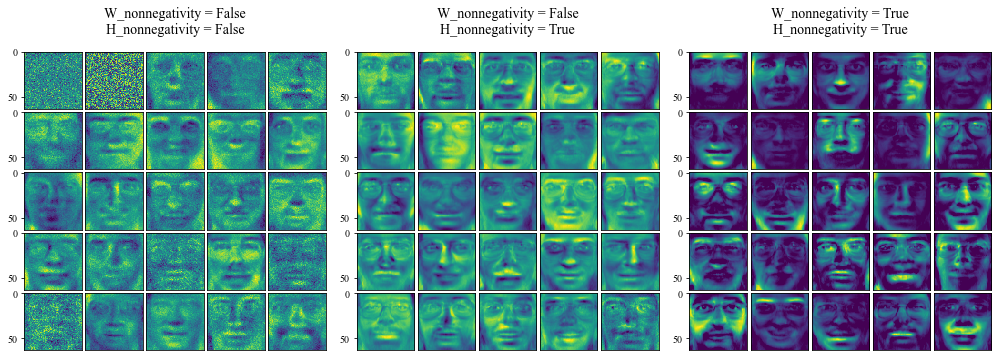

In [69]:
# Variable nonnegativity constraints 

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

n_iter = 200
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex1.pdf")



  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  0%|          | 1/200 [00:00<01:53,  1.75it/s]

iteration 0, reconstruction error 69834.630434


  6%|▌         | 11/200 [00:06<01:51,  1.70it/s]

iteration 10, reconstruction error 16323.689501


 10%|█         | 21/200 [00:12<01:28,  2.01it/s]

iteration 20, reconstruction error 12688.689562


 16%|█▌        | 31/200 [00:17<01:18,  2.14it/s]

iteration 30, reconstruction error 11178.486479


 20%|██        | 41/200 [00:21<01:12,  2.19it/s]

iteration 40, reconstruction error 10278.100108


 26%|██▌       | 51/200 [00:27<01:34,  1.58it/s]

iteration 50, reconstruction error 9700.549808


 30%|███       | 61/200 [00:34<01:41,  1.36it/s]

iteration 60, reconstruction error 9294.198752


 36%|███▌      | 71/200 [00:39<00:57,  2.24it/s]

iteration 70, reconstruction error 9021.424868


 40%|████      | 81/200 [00:44<00:58,  2.04it/s]

iteration 80, reconstruction error 8826.484244


 46%|████▌     | 91/200 [00:48<00:49,  2.22it/s]

iteration 90, reconstruction error 8676.129798


 50%|█████     | 101/200 [00:53<00:44,  2.25it/s]

iteration 100, reconstruction error 8551.815541


 56%|█████▌    | 111/200 [00:57<00:38,  2.29it/s]

iteration 110, reconstruction error 8447.978071


 60%|██████    | 121/200 [01:01<00:35,  2.24it/s]

iteration 120, reconstruction error 8361.339756


 66%|██████▌   | 131/200 [01:05<00:28,  2.41it/s]

iteration 130, reconstruction error 8288.143034


 70%|███████   | 141/200 [01:10<00:24,  2.44it/s]

iteration 140, reconstruction error 8229.897106


 76%|███████▌  | 151/200 [01:14<00:20,  2.39it/s]

iteration 150, reconstruction error 8180.732698


 80%|████████  | 161/200 [01:18<00:15,  2.50it/s]

iteration 160, reconstruction error 8143.383894


 86%|████████▌ | 171/200 [01:22<00:12,  2.35it/s]

iteration 170, reconstruction error 8104.779908


 90%|█████████ | 181/200 [01:26<00:07,  2.38it/s]

iteration 180, reconstruction error 8075.442329


 96%|█████████▌| 191/200 [01:30<00:03,  2.45it/s]

iteration 190, reconstruction error 8039.781079


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, True]


  0%|          | 1/200 [00:00<01:29,  2.23it/s]

iteration 0, reconstruction error 25270.660133


  6%|▌         | 11/200 [00:05<01:30,  2.09it/s]

iteration 10, reconstruction error 8588.457616


 10%|█         | 21/200 [00:09<01:27,  2.05it/s]

iteration 20, reconstruction error 7528.443444


 16%|█▌        | 31/200 [00:14<01:15,  2.25it/s]

iteration 30, reconstruction error 7112.401113


 20%|██        | 41/200 [00:18<01:11,  2.22it/s]

iteration 40, reconstruction error 6951.045118


 26%|██▌       | 51/200 [00:23<01:06,  2.26it/s]

iteration 50, reconstruction error 6865.713193


 30%|███       | 61/200 [00:27<01:03,  2.18it/s]

iteration 60, reconstruction error 6805.426823


 36%|███▌      | 71/200 [00:32<00:54,  2.35it/s]

iteration 70, reconstruction error 6767.468292


 40%|████      | 81/200 [00:37<01:14,  1.61it/s]

iteration 80, reconstruction error 6740.087628


 46%|████▌     | 91/200 [00:43<01:17,  1.41it/s]

iteration 90, reconstruction error 6717.137059


 50%|█████     | 101/200 [00:50<01:01,  1.62it/s]

iteration 100, reconstruction error 6695.231076


 56%|█████▌    | 111/200 [00:57<00:54,  1.63it/s]

iteration 110, reconstruction error 6674.058785


 60%|██████    | 121/200 [01:03<00:48,  1.63it/s]

iteration 120, reconstruction error 6654.303810


 66%|██████▌   | 131/200 [01:09<00:35,  1.95it/s]

iteration 130, reconstruction error 6637.061029


 70%|███████   | 141/200 [01:13<00:26,  2.27it/s]

iteration 140, reconstruction error 6623.419858


 76%|███████▌  | 151/200 [01:18<00:27,  1.81it/s]

iteration 150, reconstruction error 6612.308047


 80%|████████  | 161/200 [01:24<00:23,  1.67it/s]

iteration 160, reconstruction error 6604.129514


 86%|████████▌ | 171/200 [01:31<00:18,  1.61it/s]

iteration 170, reconstruction error 6597.853640


 90%|█████████ | 181/200 [01:35<00:09,  1.95it/s]

iteration 180, reconstruction error 6592.980909


 96%|█████████▌| 191/200 [01:40<00:04,  2.13it/s]

iteration 190, reconstruction error 6589.709843


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [True, True]


  0%|          | 1/200 [00:00<01:27,  2.27it/s]

iteration 0, reconstruction error 25386.795374


  6%|▌         | 11/200 [00:04<01:27,  2.16it/s]

iteration 10, reconstruction error 9173.207006


 10%|█         | 21/200 [00:09<01:25,  2.11it/s]

iteration 20, reconstruction error 7963.522213


 16%|█▌        | 31/200 [00:13<01:13,  2.29it/s]

iteration 30, reconstruction error 7565.472137


 20%|██        | 41/200 [00:18<01:13,  2.16it/s]

iteration 40, reconstruction error 7358.408457


 26%|██▌       | 51/200 [00:22<01:04,  2.30it/s]

iteration 50, reconstruction error 7226.158928


 30%|███       | 61/200 [00:26<00:59,  2.35it/s]

iteration 60, reconstruction error 7157.482282


 36%|███▌      | 71/200 [00:31<00:55,  2.32it/s]

iteration 70, reconstruction error 7120.031843


 40%|████      | 81/200 [00:35<00:53,  2.22it/s]

iteration 80, reconstruction error 7095.233537


 46%|████▌     | 91/200 [00:39<00:46,  2.36it/s]

iteration 90, reconstruction error 7077.057121


 50%|█████     | 101/200 [00:43<00:42,  2.34it/s]

iteration 100, reconstruction error 7062.553871


 56%|█████▌    | 111/200 [00:48<00:37,  2.35it/s]

iteration 110, reconstruction error 7050.614854


 60%|██████    | 121/200 [00:52<00:33,  2.39it/s]

iteration 120, reconstruction error 7040.452612


 66%|██████▌   | 131/200 [00:56<00:29,  2.36it/s]

iteration 130, reconstruction error 7031.637493


 70%|███████   | 141/200 [01:00<00:24,  2.38it/s]

iteration 140, reconstruction error 7023.822492


 76%|███████▌  | 151/200 [01:04<00:20,  2.41it/s]

iteration 150, reconstruction error 7016.842525


 80%|████████  | 161/200 [01:09<00:16,  2.38it/s]

iteration 160, reconstruction error 7010.521665


 86%|████████▌ | 171/200 [01:13<00:12,  2.36it/s]

iteration 170, reconstruction error 7004.655505


 90%|█████████ | 181/200 [01:17<00:08,  2.33it/s]

iteration 180, reconstruction error 6999.178265


 96%|█████████▌| 191/200 [01:21<00:03,  2.36it/s]

iteration 190, reconstruction error 6994.107997


100%|██████████| 200/200 [01:25<00:00,  2.34it/s]


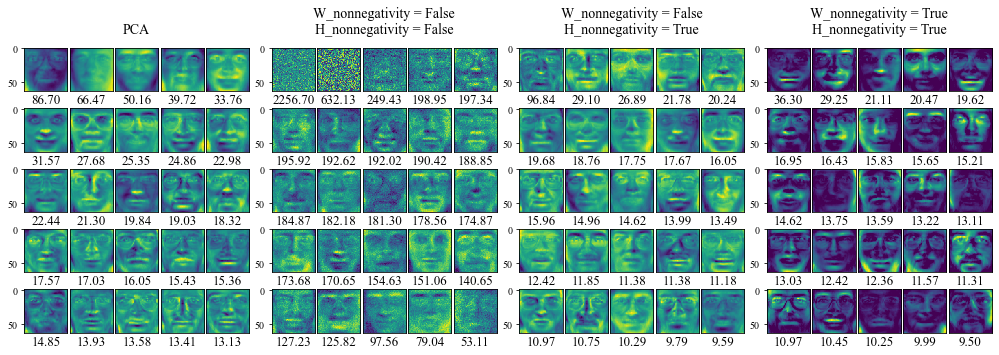

In [109]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex1.pdf")

In [ ]:
# Variable regularizer for W

X0 = faces_centered.T
print('X0.shape', X0.shape)

n_iter = 200
W_list = []

W_sparsity = [[0, 0], [0.5, 0], [0, 3]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)

display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex2.pdf")

  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  0%|          | 1/200 [00:00<01:23,  2.39it/s]

iteration 0, reconstruction error 25160.447748


  6%|▌         | 11/200 [00:04<01:28,  2.14it/s]

iteration 10, reconstruction error 9378.973911


 10%|█         | 21/200 [00:10<01:47,  1.67it/s]

iteration 20, reconstruction error 8149.204106


 16%|█▌        | 31/200 [00:17<01:33,  1.81it/s]

iteration 30, reconstruction error 7669.232503


 20%|██        | 41/200 [00:21<01:11,  2.23it/s]

iteration 40, reconstruction error 7403.178651


 26%|██▌       | 51/200 [00:26<01:08,  2.17it/s]

iteration 50, reconstruction error 7228.598708


 30%|███       | 61/200 [00:30<01:01,  2.26it/s]

iteration 60, reconstruction error 7153.703506


 36%|███▌      | 71/200 [00:35<00:54,  2.35it/s]

iteration 70, reconstruction error 7108.930319


 40%|████      | 81/200 [00:39<00:55,  2.14it/s]

iteration 80, reconstruction error 7079.087363


 46%|████▌     | 91/200 [00:43<00:48,  2.23it/s]

iteration 90, reconstruction error 7059.527849


 50%|█████     | 101/200 [00:49<01:10,  1.40it/s]

iteration 100, reconstruction error 7046.138219


 56%|█████▌    | 111/200 [00:57<01:04,  1.39it/s]

iteration 110, reconstruction error 7036.381090


 60%|██████    | 121/200 [01:02<00:47,  1.66it/s]

iteration 120, reconstruction error 7028.936028


 66%|██████▌   | 131/200 [01:09<00:42,  1.63it/s]

iteration 130, reconstruction error 7022.887447


 70%|███████   | 141/200 [01:15<00:35,  1.65it/s]

iteration 140, reconstruction error 7017.694223


 76%|███████▌  | 151/200 [01:21<00:30,  1.59it/s]

iteration 150, reconstruction error 7013.019612


 80%|████████  | 161/200 [01:27<00:23,  1.68it/s]

iteration 160, reconstruction error 7008.721077


 86%|████████▌ | 171/200 [01:33<00:17,  1.67it/s]

iteration 170, reconstruction error 7004.731618


 90%|█████████ | 181/200 [01:41<00:18,  1.03it/s]

iteration 180, reconstruction error 7001.078526


 96%|█████████▌| 191/200 [01:49<00:07,  1.29it/s]

iteration 190, reconstruction error 6997.668232


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, True]


  0%|          | 1/200 [00:00<02:09,  1.54it/s]

iteration 0, reconstruction error 26625.191282


  6%|▌         | 11/200 [00:06<01:58,  1.60it/s]

iteration 10, reconstruction error 9255.456567


 10%|█         | 21/200 [00:12<01:45,  1.70it/s]

iteration 20, reconstruction error 8301.751059


 16%|█▌        | 31/200 [00:19<01:51,  1.52it/s]

iteration 30, reconstruction error 7820.664866


 20%|██        | 41/200 [00:25<01:36,  1.64it/s]

iteration 40, reconstruction error 7605.828264


 26%|██▌       | 51/200 [00:31<01:30,  1.65it/s]

iteration 50, reconstruction error 7530.003001


 30%|███       | 61/200 [00:37<01:22,  1.69it/s]

iteration 60, reconstruction error 7518.120920


 36%|███▌      | 71/200 [00:43<01:17,  1.67it/s]

iteration 70, reconstruction error 7483.682707


 40%|████      | 81/200 [00:49<01:11,  1.66it/s]

iteration 80, reconstruction error 7453.971627


 46%|████▌     | 91/200 [00:55<01:03,  1.70it/s]

iteration 90, reconstruction error 7431.150008


 50%|█████     | 101/200 [01:01<00:57,  1.71it/s]

iteration 100, reconstruction error 7412.746387


 56%|█████▌    | 111/200 [01:06<00:52,  1.68it/s]

iteration 110, reconstruction error 7397.992973


 60%|██████    | 121/200 [01:11<00:34,  2.31it/s]

iteration 120, reconstruction error 7386.008419


 66%|██████▌   | 131/200 [01:15<00:27,  2.52it/s]

iteration 130, reconstruction error 7375.909323


 70%|███████   | 141/200 [01:19<00:23,  2.53it/s]

iteration 140, reconstruction error 7367.268448


 76%|███████▌  | 151/200 [01:23<00:19,  2.50it/s]

iteration 150, reconstruction error 7359.656259


 80%|████████  | 161/200 [01:27<00:15,  2.47it/s]

iteration 160, reconstruction error 7352.670604


 86%|████████▌ | 171/200 [01:31<00:11,  2.49it/s]

iteration 170, reconstruction error 7346.210335


 90%|█████████ | 181/200 [01:35<00:07,  2.51it/s]

iteration 180, reconstruction error 7340.336351


 96%|█████████▌| 191/200 [01:39<00:03,  2.50it/s]

iteration 190, reconstruction error 7334.948860


  0%|          | 0/200 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [True, True]


  0%|          | 1/200 [00:00<01:19,  2.51it/s]

iteration 0, reconstruction error 44098.892971


  6%|▌         | 11/200 [00:04<01:19,  2.39it/s]

iteration 10, reconstruction error 9813.275235


 10%|█         | 21/200 [00:08<01:18,  2.27it/s]

iteration 20, reconstruction error 8904.545981


 16%|█▌        | 31/200 [00:13<01:11,  2.38it/s]

iteration 30, reconstruction error 8489.643313


 20%|██        | 41/200 [00:17<01:10,  2.26it/s]

iteration 40, reconstruction error 8229.071616


 26%|██▌       | 51/200 [00:21<01:02,  2.39it/s]

iteration 50, reconstruction error 8008.250063


 30%|███       | 61/200 [00:25<00:57,  2.43it/s]

iteration 60, reconstruction error 7829.825073


 36%|███▌      | 71/200 [00:29<00:53,  2.40it/s]

iteration 70, reconstruction error 7689.286444


 40%|████      | 81/200 [00:33<00:49,  2.38it/s]

iteration 80, reconstruction error 7579.427541


 46%|████▌     | 91/200 [00:38<00:45,  2.42it/s]

iteration 90, reconstruction error 7492.957558


 50%|█████     | 101/200 [00:42<00:41,  2.41it/s]

iteration 100, reconstruction error 7425.186046


 56%|█████▌    | 111/200 [00:46<00:36,  2.42it/s]

iteration 110, reconstruction error 7372.354917


 60%|██████    | 121/200 [00:50<00:33,  2.39it/s]

iteration 120, reconstruction error 7330.912669


 66%|██████▌   | 131/200 [00:54<00:28,  2.38it/s]

iteration 130, reconstruction error 7298.090357


 70%|███████   | 141/200 [00:58<00:24,  2.41it/s]

iteration 140, reconstruction error 7271.538635


 76%|███████▌  | 151/200 [01:02<00:20,  2.42it/s]

iteration 150, reconstruction error 7249.342179


 80%|████████  | 161/200 [01:07<00:16,  2.31it/s]

iteration 160, reconstruction error 7230.392442


 86%|████████▌ | 171/200 [01:11<00:12,  2.39it/s]

iteration 170, reconstruction error 7213.961929


 90%|█████████ | 181/200 [01:15<00:07,  2.42it/s]

iteration 180, reconstruction error 7199.570132


 96%|█████████▌| 191/200 [01:19<00:03,  2.41it/s]

iteration 190, reconstruction error 7186.904903


100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


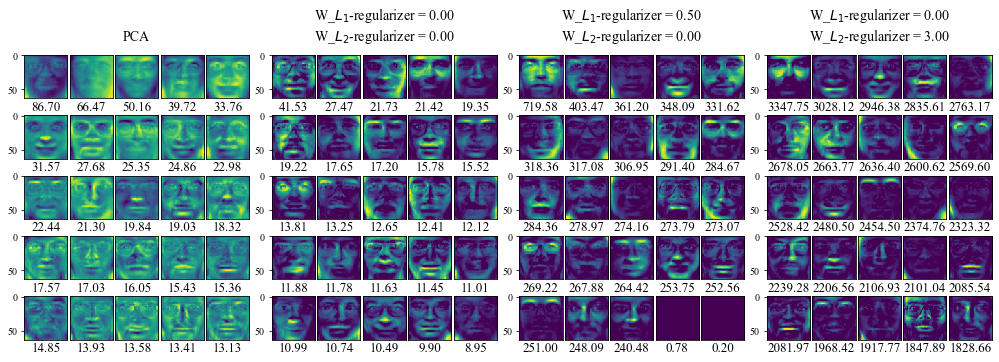

In [110]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

W_sparsity = ['PCA', [0, 0], [0.5, 0], [0, 3]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)


label_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex2.pdf")

## Topic modeling for 20Newsgroups dataset

In [112]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import entropy
import pandas as pd

In [113]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [114]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])

len(newsgroups_labels) 5616
newsgroups_labels [0 1 8 ... 8 1 2]
data_cleaned[1] .  Why, or how actually, can a Powerbook have a  x  pixel
    display, regardless if it is a " or ", and still keep the
     dpi resolution?  (I assume that it doesn't, and I don't 
    mean to imply they *all* have these dimensions)


.  Any info on price drops or new models (non-Duo) coming up?


newsgroups_labels[1] 1


In [115]:
# vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectorizer_BOW = CountVectorizer(stop_words=stopwords_list)
vectors_BOW = vectorizer_BOW.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
# print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

count_list = []
word_list = []

for j in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][j]
    # print('>>>> %i th coordinate <===> %s, count %i' % (idx, idx_to_word[idx], vectors[idx, i]))
    count_list.append([idx, vectors_BOW[idx, i], vectors[idx, i]])
    word_list.append(idx_to_word[idx])

d = pd.DataFrame(data=np.asarray(count_list).T, columns=word_list).T
d.columns = ['Coordinate', 'Bag-of-words', 'tf-idf']
cols = ['Coordinate', 'Bag-of-words']
d[cols] = d[cols].applymap(np.int64)

print(d)

>>>> vectors.shape (45534, 5616)
newsgroups_labels[i] 1
>>>> data_cleaned[i] Anyone know what would cause my IIcx to not turn on when I hit the keyboard
switch?  The one in the back of the machine doesn't work either...
The only way I can turn it on is to unplug the machine for a few minutes,
then plug it back in and hit the power switch in the back immediately...
Sometimes this doesn't even work for a long time...

I remember hearing about this problem a long time ago, and that a logic 
board failure was mentioned as the source of the problem...is this true?

             Coordinate  Bag-of-words    tf-idf
ago                1286             1  0.115122
back               3503             3  0.288116
board              4850             1  0.138195
cause              6355             1  0.125130
either            12551             1  0.108417
failure           14215             1  0.170555
hearing           17842             1  0.170555
hit               18278             2  0.261832
i

In [159]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'tf-idf', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'sci.med',
     'sci.space',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.religion.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2,3,4,5,6,7,8,9], 
                                                                       vectorizer = 'tf-idf',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
#print('y_list', onehot2list(y_test))

!! X.shape (5616, 45534)
X_train.shape (4483, 45534)
X_test.shape (1133, 45534)
y_train.shape (4483, 10)
y_test.shape (1133, 10)
y_test [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [160]:
idx2word = data_dict.get('idx2word')
categories = data_dict.get('categories')

In [161]:
import random 

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def plot_topic_wordcloud(W, idx2word, num_keywords_in_topic=5, save_name=None):
        # plot the class-conditioanl PMF as wordclouds 
        # W = (p x r) (words x topic)
        # idx2words = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(W.shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx = np.argsort(W[:,i])
            idx = np.flip(idx)    
           
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx[j]])
                
            Y = " ".join(list_words)
            #stopwords = STOPWORDS
            #stopwords.update(["’", "“", "”", "000", "000 000", "https", "co", "19", "2019", "coronavirus",
            #                  "virus", "corona", "covid", "ncov", "covid19", "amp"])
            wc = WordCloud(background_color="black",
                                  relative_scaling=0,
                                  width=400,
                                  height=400).generate(Y)
            
            ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
                                 interpolation="bilinear")
            
            # ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')

In [182]:
X0 = X_train.T

print('X0.shape', X0.shape)

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=1, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)



  0%|          | 0/1 [00:00<?, ?it/s]

X0.shape (45534, 4483)


100%|██████████| 1/1 [00:15<00:00, 15.70s/it]

iteration 0, reconstruction error 1471043.195916


In [190]:
print(W[:,0])

print('idx2word[100]', idx2word[100])

[0.30294269 0.09398598 0.32478796 ... 0.         0.07218221 0.39106699]
idx2word[100] _broken_


  5%|▌         | 1/20 [00:09<03:02,  9.60s/it]

iteration 0, reconstruction error 1475972.788767


 55%|█████▌    | 11/20 [01:26<01:13,  8.19s/it]

iteration 10, reconstruction error 752429.085204


100%|██████████| 20/20 [02:40<00:00,  8.00s/it]


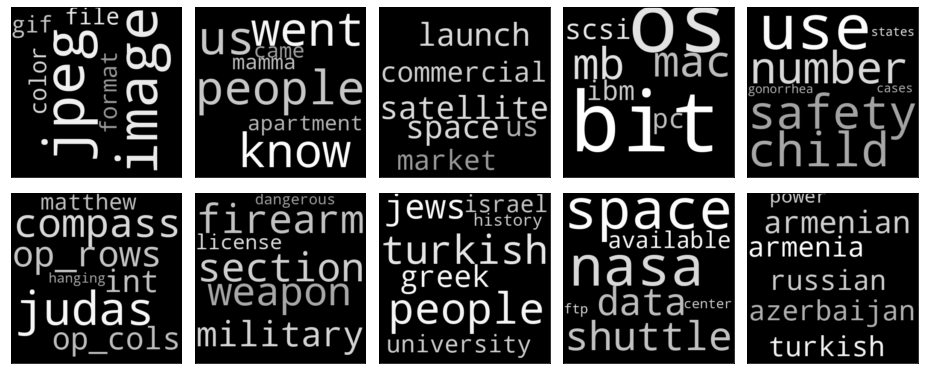

In [162]:
# Topic modeling by NMF
X0 = X_train.T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)

plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, save_name="20NEWS_topic1.pdf")


  5%|▌         | 1/20 [00:09<03:04,  9.70s/it]

iteration 0, reconstruction error 7289997.547803


 55%|█████▌    | 11/20 [01:31<01:20,  8.93s/it]

iteration 10, reconstruction error 1502985.233679


100%|██████████| 20/20 [02:47<00:00,  8.37s/it]


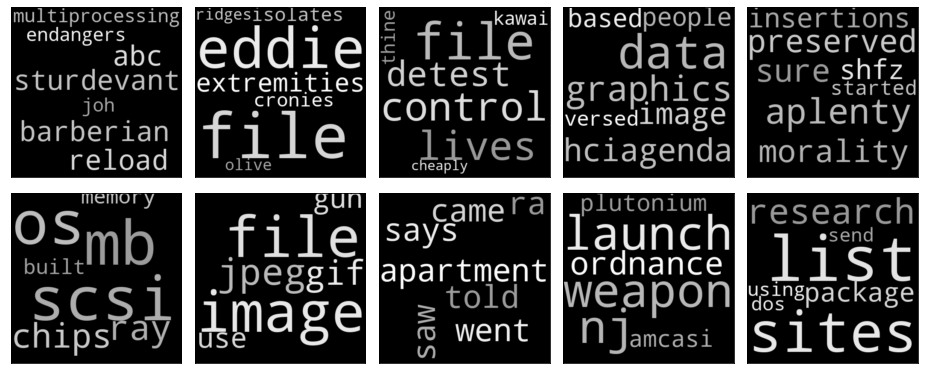

In [163]:
# Topic modeling by NMF
X0 = X_train.T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=False,
           compute_recons_error=True)


plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, save_name="20NEWS_topic2.pdf")